In [1]:
import torch
from torchvision.datasets import MNIST
import os

/home/lyc/anaconda3/envs/orl-cuda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset = MNIST(root='./data', train=True, download=True)
eval_dataset = MNIST(root='./data', train=False, download=True)

In [3]:
folder_path = 'save/sde-flow/default/mnist-True-True-64-0.0001-100000/'
gen_sde, optim, not_finished, count = torch.load(os.path.join(folder_path, 'checkpoint.pt'))

In [11]:
from lib.plotting import get_grid, get_grid_corrector
from lib.flows.elemwise import LogitTransform
import matplotlib.pyplot as plt
reverse = LogitTransform(alpha=0.05).reverse

y0 = get_grid(gen_sde, 1, 28, 4, 1000, reverse)
y1 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=1e-2)
y2 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=3e-3)
y3 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=1e-3) # 似乎这个好
y4 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=3e-4)
y5 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=1e-4)
y6 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=3e-5)
y7 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=1e-5)

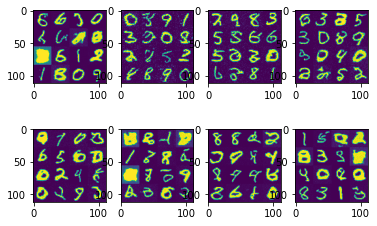

In [12]:

fig, axs = plt.subplots(2, 4)
axs[0][0].imshow(y0.squeeze())
axs[0][1].imshow(y1.squeeze())
axs[0][2].imshow(y2.squeeze())
axs[0][3].imshow(y3.squeeze())
axs[1][0].imshow(y4.squeeze())
axs[1][1].imshow(y5.squeeze())
axs[1][2].imshow(y6.squeeze())
axs[1][3].imshow(y7.squeeze())